#### Import Libraries

In [1]:
import os
from random import sample
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import gridspec
from StructureDataModule import structure_data
from PIL import Image
from skimage import transform

In [2]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.initializers import GlorotUniform
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

#### Structuring data files

In [3]:
structure_data()

Files moved succesfully!


#### Image Preprocessing

In [4]:
trainset_path = './input/train_set'
valset_path = './input/validation_set'
testset_path = './input/test_set'

(384, 512, 3)


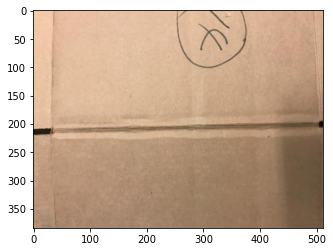

In [5]:
test_img = plt.imread('./input/train_set/cardboard/cardboard1.jpg')
print(test_img.shape)
plt.imshow(test_img)

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    trainset_path,
    target_size = (150, 150),
    batch_size = 64,
    class_mode = 'categorical'
)

Found 1768 images belonging to 6 classes.


In [7]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [8]:
val_datagen = ImageDataGenerator(
    rescale = 1/255.
)

val_generator = val_datagen.flow_from_directory(
    valset_path,
    target_size = (150, 150),
    batch_size = 64,
    class_mode = 'categorical'
)

Found 328 images belonging to 6 classes.


### Auxiliary Functions

In [9]:
def setModelResults():
    #Get model ID
    with open('./models/model_results.csv') as file:
        lines = file.readlines()  
    model_id = len(lines)
            
    #Prepare directory
    path = './models/' + 'cnn_model{}'.format(model_id)
    if not os.path.exists(path):
        os.makedirs(path)       
        
    return model_id

In [10]:
def writeModelResults(results, model):
    results.to_csv('./results/model_results.csv', mode = 'a', header = False, index = False)
    print('Model results saved succesfully')
    return 

### CNN Model

In [11]:
model_id = setModelResults()
model_id

4

##### Callbacks

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

In [13]:
stop_cb = myCallback()

In [14]:
checkpoint_path = './models/cnn_model{}/weights_cp.ckpt'.format(model_id)

In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 save_best_only = True,
                                                 verbose=1)

##### Model

In [17]:
base_model = InceptionV3(weights='imagenet', input_shape=(150, 150, 3), include_top=False)   
last_layer = base_model.get_layer('mixed7')

In [18]:
#freeze base model trainable params
for layer in base_model.layers:
    layer.trainable = False

# new top layers
x = last_layer.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_initializer = GlorotUniform())(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer = GlorotUniform())(x)
x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)

#create new model
model = Model(inputs = base_model.input, outputs = x)

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [20]:
model_path = './models/cnn_model{}/cnn_model.h5'.format(model_id)
model.save(model_path)

In [21]:
%%time
history = model.fit(
     x = train_generator
    ,epochs = 30
    ,validation_data = val_generator
    ,callbacks = [stop_cb, cp_callback]
)

Epoch 1/30
28/28 [==============================] - 52s 737ms/step - loss: 1.1449 - accuracy: 0.5622 - val_loss: 0.7459 - val_accuracy: 0.7043

Epoch 00001: val_accuracy improved from -inf to 0.70427, saving model to ./models/cnn_model4\weights_cp.ckpt
Epoch 2/30
28/28 [==============================] - 14s 484ms/step - loss: 0.6735 - accuracy: 0.7483 - val_loss: 0.5939 - val_accuracy: 0.7561

Epoch 00002: val_accuracy improved from 0.70427 to 0.75610, saving model to ./models/cnn_model4\weights_cp.ckpt
Epoch 3/30
28/28 [==============================] - 14s 502ms/step - loss: 0.5383 - accuracy: 0.8128 - val_loss: 0.5622 - val_accuracy: 0.7957

Epoch 00003: val_accuracy improved from 0.75610 to 0.79573, saving model to ./models/cnn_model4\weights_cp.ckpt
Epoch 4/30
28/28 [==============================] - 14s 506ms/step - loss: 0.4579 - accuracy: 0.8450 - val_loss: 0.4918 - val_accuracy: 0.8232

Epoch 00004: val_accuracy improved from 0.79573 to 0.82317, saving model to ./models/cnn_mo

##### Evaluate training results

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

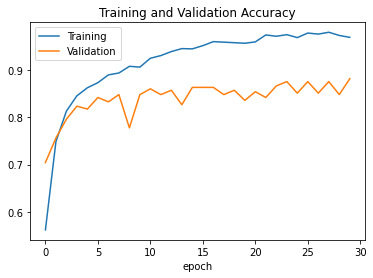

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

#### Predictions

In [25]:
test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

test_generator = test_datagen.flow_from_directory(
    testset_path,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 431 images belonging to 6 classes.


In [26]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

14/14 [==============================] - 3s 161ms/step - loss: 0.5696 - accuracy: 0.8561
Test loss: 0.569600522518158 Test Acc: 0.8561484813690186


### Save model results

In [27]:
results = pd.DataFrame({'Model_ID': model_id, 'Model_path': model_path, 'Weights_path': checkpoint_path, 'Accuracy': test_acc}, index = [0])
results

,Model_ID,Model_path,Weights_path,Accuracy
0,4,./models/cnn_model4/cnn_model.h5,./models/cnn_model4/weights_cp.ckpt,0.856148


In [28]:
results.to_csv('./models/model_results.csv', mode = 'a', header = False, index = False)

#### Plotting ConvLayers Activations

In [29]:
def getImgSamples(path, n = 1):
    imgs = dict()
    for img_class in os.listdir(path):
        class_path = os.path.join(path, img_class)
        imgs[img_class]  = sample(os.listdir(class_path), n)
    
    return imgs

In [30]:
def plotSampleImgs(imgs):
    fig, axs = plt.subplots(nrows = 1, ncols = 6, figsize = (24,24))
    col = 0
    for img_class, img_name in imgs.items():
        img_path = os.path.join(testset_path, img_class, img_name[0])
        img = load_img(img_path, target_size = (128,128))
        axs[col].imshow(img)
        axs[col].set_title('{}'.format(img_class))
        col += 1
        
    plt.subplots_adjust(wspace=1.3, hspace=1.3)
    plt.show()
    return

In [31]:
sample_imgs = getImgSamples(testset_path, 1)
sample_imgs

{'cardboard': ['cardboard9.jpg'],
 'glass': ['glass323.jpg'],
 'metal': ['metal143.jpg'],
 'paper': ['paper558.jpg'],
 'plastic': ['plastic423.jpg'],
 'trash': ['trash12.jpg']}

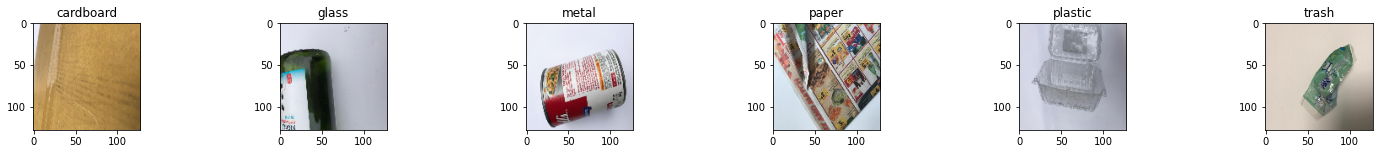

In [32]:
plotSampleImgs(sample_imgs)

In [35]:
def plotFeaturesMaps(model, path, img_class, imgs, layer_number = 2):

    #Get convolution and pooling layers to plot
    names = [layer.name for layer in model.layers if ('conv' in layer.name)]
    outputs = [layer.output for layer in model.layers if ('conv' in layer.name)]
    
    names = names[:2]
    outputs = outputs[:2]
    
    # redefine model to output right after the first hidden layer
    feature_map_model = Model(inputs = model.inputs, outputs = outputs)
    
    #Get and prepare the image
    img_path = os.path.join(path, img_class, imgs[img_class][0])
    img = load_img(img_path, target_size=(150, 150))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    
    #Get feature maps(activations)
    feature_maps = feature_map_model.predict(img)
    
    for layer_name, feature_map in zip(names, feature_maps):    
        k = feature_map.shape[-1] #number of filters applied on the layer
        nrow = k//8
        ncol = 8
        
        fig = plt.figure(figsize=(ncol+1, nrow+1)) 
        gs = gridspec.GridSpec(nrow, ncol,
                 wspace=0.0, hspace=0.0, 
                 top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
                 left=0.5/(ncol+1), right=1-0.5/(ncol+1))  

        for i in range(nrow):
            for j in range(ncol):
                feature_img = feature_map[0, :, :, i]
                ax = plt.subplot(gs[i,j])
                ax.imshow(feature_img)
                ax.set_xticks([])
                ax.set_yticks([])

        #gs.title('Layer {}: {}'.format(i, layer_name))     
        print('Layer {}: {}'.format(i, layer_name)) 
        plt.show()
            
    return

Layer 3: conv2d


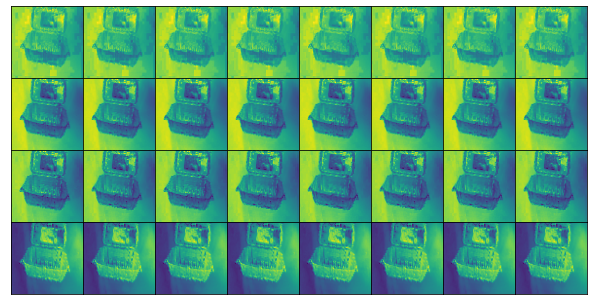

Layer 3: conv2d_1


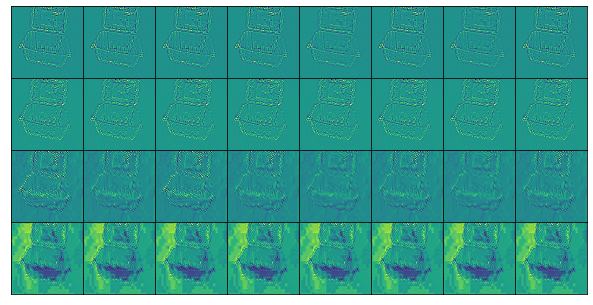

In [36]:
plotFeaturesMaps(model, testset_path, 'plastic', sample_imgs)

### Get Best Model

In [43]:
from PIL import Image
from skimage import transform

In [37]:
models_df = pd.read_csv('./models/model_results.csv')
models_df.sort_values(by = 'Accuracy', ascending = False, ignore_index = True, inplace = True)
models_df.head()

,Model_ID,Model_path,Weights_path,Accuracy
0,4,./models/cnn_model4/cnn_model.h5,./models/cnn_model4/weights_cp.ckpt,0.856148
1,3,./models/cnn_model3/cnn_model.h5,./models/cnn_model3/weights_cp.ckpt,0.846868
2,2,./models/cnn_model2/cnn_model.h5,./models/cnn_model2/weights_cp.ckpt,0.770302
3,1,./models/cnn_model1/cnn_model.h5,./models/cnn_model1/weights_cp.ckpt,0.656613


In [40]:
best_model = load_model(models_df.loc[0, 'Model_path'])
best_model.load_weights(models_df.loc[0, 'Weights_path'])

### Test Prediction

In [41]:
file_path = os.path.join(testset_path, 'plastic', sample_imgs['plastic'][0])
file_path

'./input/test_set\\plastic\\plastic423.jpg'

In [65]:
def predict_and_print(class_dict, file_path, model):
    
    #Predict class
    np_image = Image.open(file_path)
    np_image = np.array(np_image).astype('float32') / 255
    np_image = transform.resize(np_image, (150, 150, 3))
    np_image = np.expand_dims(np_image, axis = 0)
    prediction = model.predict(np_image)
    idx = np.argmax(prediction)
    
    #Get class label
    key_list = list(class_dict.keys())
    val_list = list(class_dict.values())
    pos = val_list.index(idx)
    class_lbl = key_list[pos]
    
    #Plot
    img = load_img(file_path, target_size = (128,128))
    plt.imshow(img)
    plt.title('Class label={} \nprob={:.4f}'.format(class_lbl, np.max(prediction)))
    
    return prediction, class_lbl

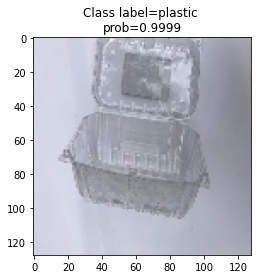

In [66]:
preds, label = predict_and_print(train_generator.class_indices, file_path, best_model)

In [58]:
preds

array([[9.19234481e-07, 1.13530776e-04, 6.43366138e-06, 7.65227378e-06,
        9.99870658e-01, 7.81761798e-07]], dtype=float32)